# What fraction of phosphorylated structures are within clusters with non-phosphorylated structures?

In [76]:
import pandas as pd
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
input_path = Path("../results/geometricus_embeddings")
subdirs = [x for x in input_path.iterdir() if x.is_dir()]

In [9]:
domain_to_cluster_df = {}
for subdir in subdirs:
    domain_name = subdir.stem
    df = pd.read_csv(subdir / "cluster_df.csv",delimiter='\t')
    domain_to_cluster_df[domain_name] = df

In [133]:
domain_to_clusters

[['PF00328', 0.8350515463917526, 3],
 ['PF02782', 0.8505154639175257, 3],
 ['PF00071', 0.812539184952978, 5],
 ['PF05202', 0.0, 0],
 ['PF00334', 0.9983844911147012, 2],
 ['PF03143', 0.9298245614035088, 3],
 ['PF02878', 0.8839285714285714, 3],
 ['PF02776', 1.0, 3],
 ['PF00905', 0.98914223669924, 3],
 ['PF00433', 0.9523809523809523, 2],
 ['PF06087', 0.967741935483871, 3],
 ['PF07804', 0.0, 0],
 ['PF02046', 0.4017857142857143, 2],
 ['PF07714', 0.9980569948186528, 2],
 ['PF00754', 0.9831223628691983, 3],
 ['PF01676', 0.98989898989899, 3],
 ['PF00521', 0.9719626168224299, 3],
 ['PF00245', 0.9416058394160584, 2],
 ['PF03098', 0.9357798165137615, 5],
 ['PF00079', 0.9592476489028213, 2],
 ['PF00240', 0.9295774647887324, 4],
 ['PF00549', 0.9461538461538461, 3],
 ['PF00300', 0.940677966101695, 6],
 ['PF00069', 0.9786017339974175, 4],
 ['PF13607', 0.0, 0],
 ['PF00884', 0.8847926267281107, 6],
 ['PF00381', 0.45714285714285713, 2],
 ['PF00026', 0.9989395546129375, 3]]

In [135]:
domain_to_clusters = []
columns = ["Domain", "Fraction clustered", "Number clusters"]

not_clustered_domains = []

for domain, cluster_df in domain_to_cluster_df.items():
    cluster_counter = Counter(cluster_df["PCA cluster"])
    total_structures = sum(cluster_counter.values())
    fraction_clustered = (total_structures - cluster_counter[-1])/total_structures
    
    if fraction_clustered == 0:
        not_clustered_domains.append(domain)
    
    cluster_labels = list(cluster_counter.keys())
    if -1 in cluster_labels: # Non-clustered examples
        cluster_labels.remove(-1)

    domain_to_clusters.append([domain, fraction_clustered,len(cluster_labels)])


In [137]:
# What fraction of phosphorylated structures are in clusters containing non-phosphorylated structures?
domain_to_fractions = []
columns = ['Domain','Not clustered','Clustered with non-phosphorylated proteins','Not clustered with non-phosphorylated proteins']
for domain, cluster_df in domain_to_cluster_df.items():
    
    if domain not in not_clustered_domains:
    
        not_clustered = 0
        clustered_with_np = 0
        not_clustered_with_np = 0

        # Find the clusters to which the non-phosphorylated structures belong to
        np_df = cluster_df.loc[cluster_df['Phosphosites'].isnull()]
        np_df = np_df.loc[np_df["PCA cluster"]!=-1]
        np_clusters = set(np_df["PCA cluster"].unique())

        # Get the clusters to which the phosphorylated structures belong to
        p_df = cluster_df.dropna()
        counter_p_clusters = Counter(p_df["PCA cluster"])
        total_p_structures = len(p_df)
        for cluster, number_structures in counter_p_clusters.items():
            if cluster == -1:
                not_clustered += number_structures
            elif cluster in np_clusters:
                clustered_with_np += number_structures
            else:
                not_clustered_with_np += number_structures
        domain_to_fractions.append([domain, not_clustered/total_p_structures, clustered_with_np/total_p_structures, not_clustered_with_np/total_p_structures])

domain_to_fractions = pd.DataFrame(domain_to_fractions, columns=columns)

In [138]:
not_clustered_domains

['PF05202', 'PF07804', 'PF13607']

In [139]:
df = domain_to_fractions.sort_values(by="Clustered with non-phosphorylated proteins",ascending=False)


In [128]:
df

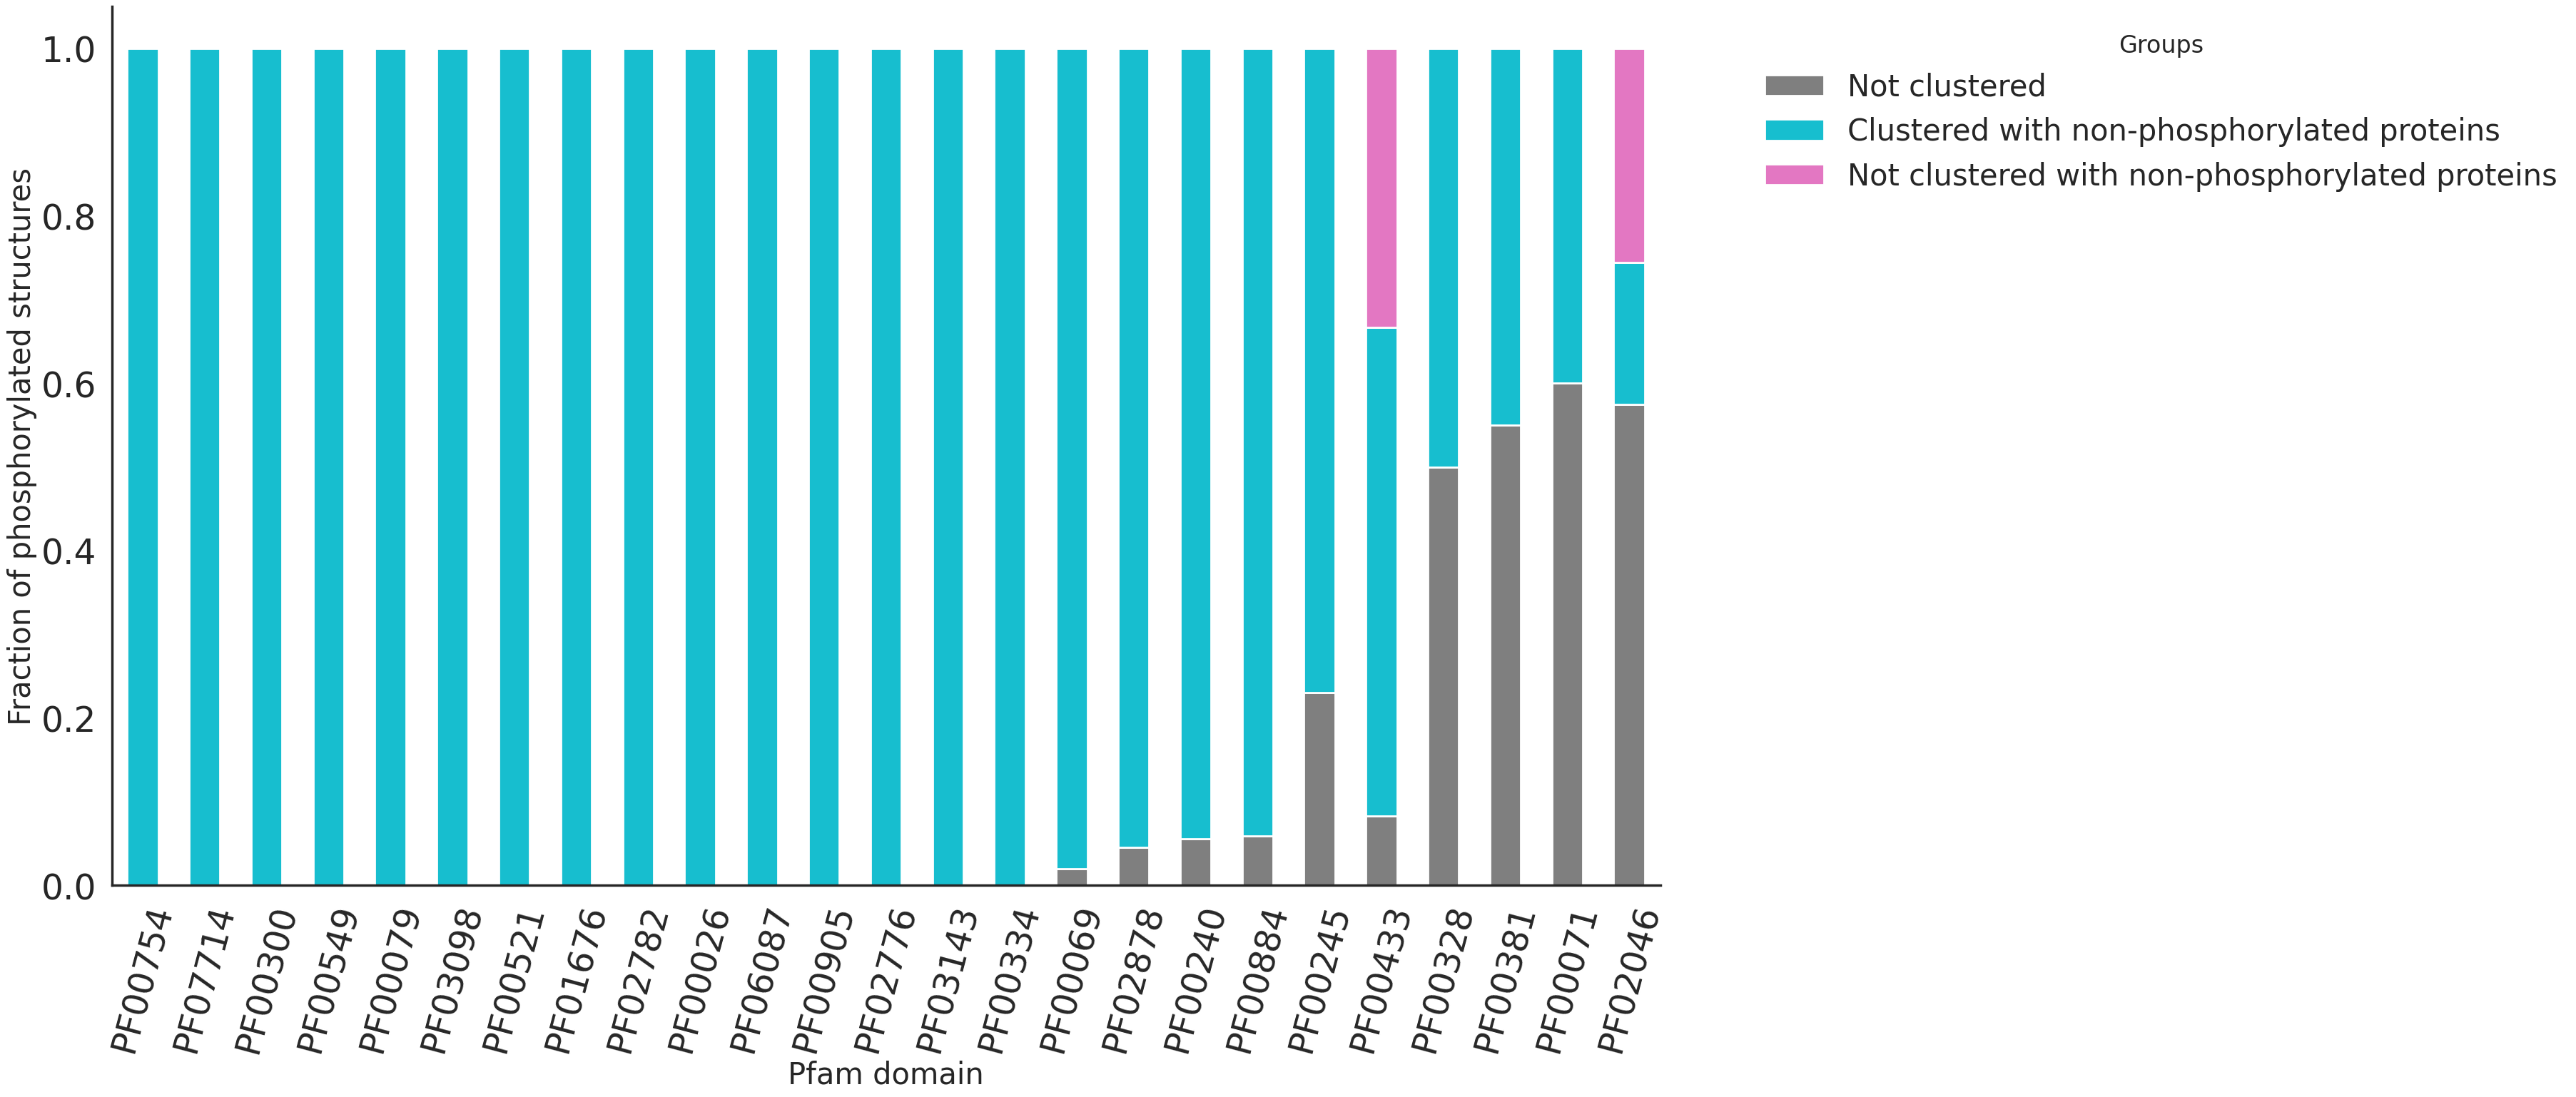

In [160]:
palette = sns.color_palette("tab10")
colors = [palette[-3],palette[-1],palette[-4]]

sns.set(style='white')
sns.set_context('poster')

df.set_index('Domain').plot(kind='bar', stacked=True, color=colors,figsize=(28,16))
plt.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False,fontsize=30)

plt.xlabel('Pfam domain',fontsize=30)
plt.ylabel('Fraction of phosphorylated structures',fontsize=30)
plt.xticks(rotation=75,fontsize=35)
plt.yticks(fontsize=35)

sns.despine()
plt.savefig("pfam_domain_fractions.pdf",dpi=150,bbox_inches='tight')